In [1]:
from glob import glob
import pandas as pd
import numpy as np
import yaml

import omnialigner as om
from omnialigner.omni_3D import Omni3D

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [9]:
import yaml

group_id = 56
overwrite_cache = False
with open("/cluster/home/bqhu_jh/projects/omni/config/Acrobat/config_Acrobat.yaml", 'r') as f:
    template_string = f.read()
    config_info = yaml.load(template_string, Loader=yaml.FullLoader)

config_info["kpt"]["n_angles"] = 20
config_info["datasets"]["group"] = f"val_{group_id}"

om_data = Omni3D(config_info=config_info)

zoom_level = 3
om_data.set_zoom_level(zoom_level)

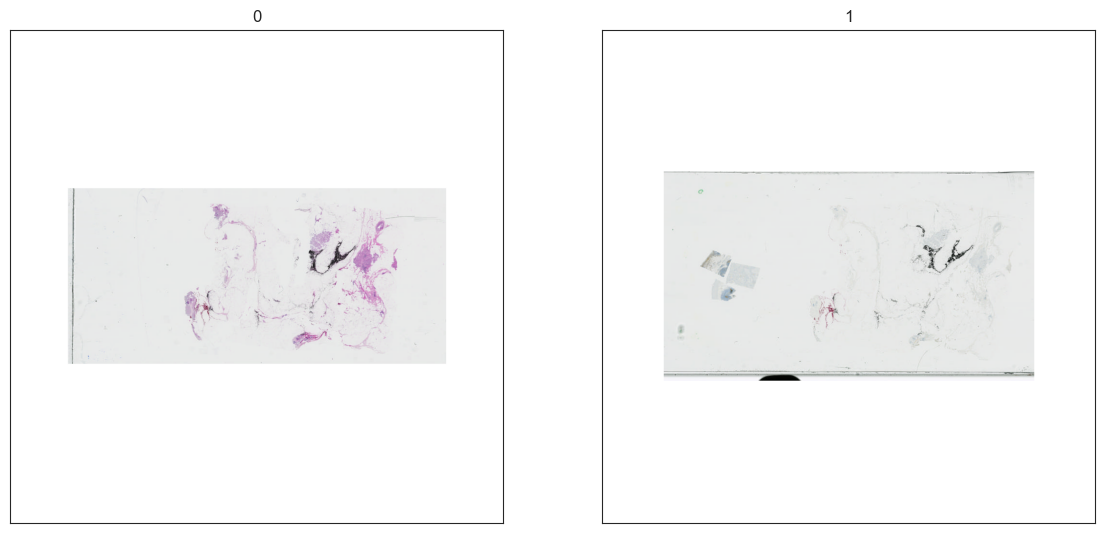

In [10]:
om.pp.pad(om_data, overwrite_cache=overwrite_cache)
om.pl.plot_nchw_2d(om_data, aligned_tag="PAD")


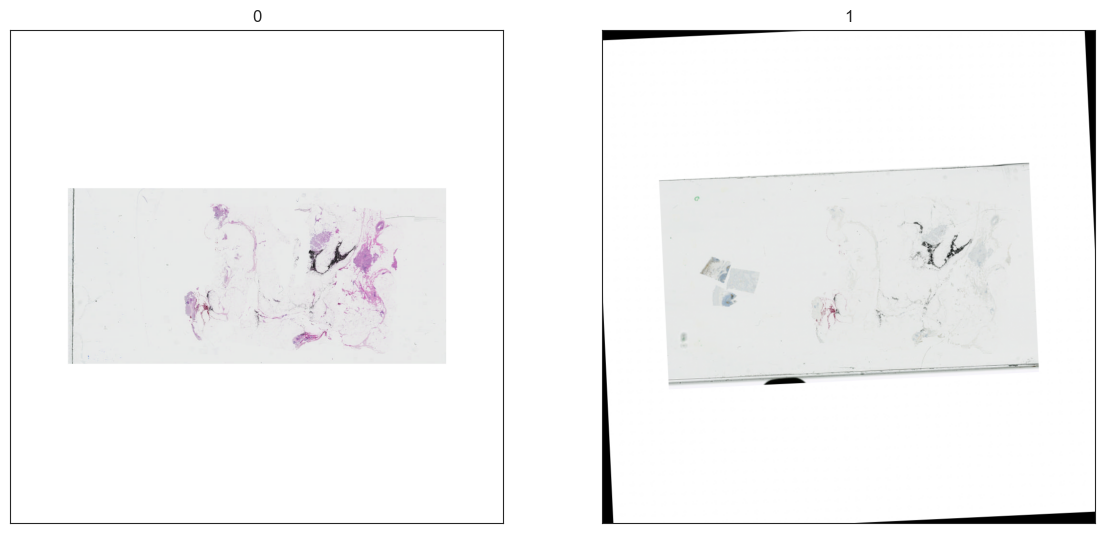

In [11]:
om.align.stack(om_data, overwrite_cache=overwrite_cache)
om.pl.plot_nchw_2d(om_data, aligned_tag="STACK")


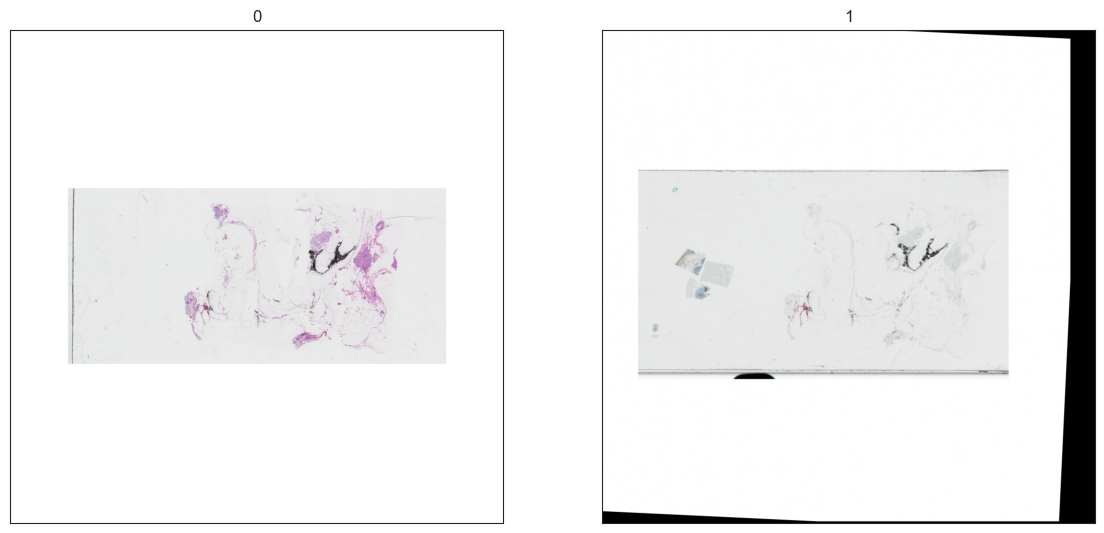

In [12]:
om.align.stack(om_data, overwrite_cache=overwrite_cache)
om.pl.plot_nchw_2d(om_data, aligned_tag="AFFINE")


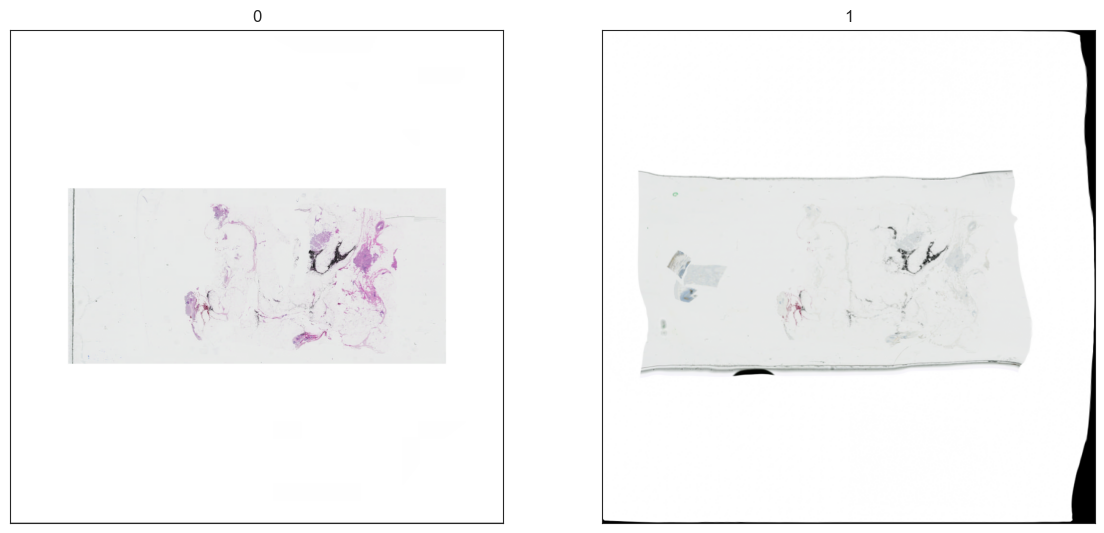

In [13]:
om.align.stack(om_data, overwrite_cache=overwrite_cache)
om.pl.plot_nchw_2d(om_data, aligned_tag="NONRIGID")


In [14]:
df_Acrobat_kpts = pd.read_csv("/cluster/home/bqhu_jh/projects/omni/benchmark/Acrobat/ACROBAT_validation_annotated_kps.csv", index_col=0).dropna()
df_sub = df_Acrobat_kpts[df_Acrobat_kpts["anon_id"] == group_id]
np_lm_M = df_sub[["ihc_x", "ihc_y"]].values / df_sub["mpp_ihc_10X"].values[:, None]
np_lm_F = df_sub[["he_x", "he_y"]].values / df_sub["mpp_he_10X"].values[:, None]


Text(0.5, 1.0, 'rtre=9.48e-04')

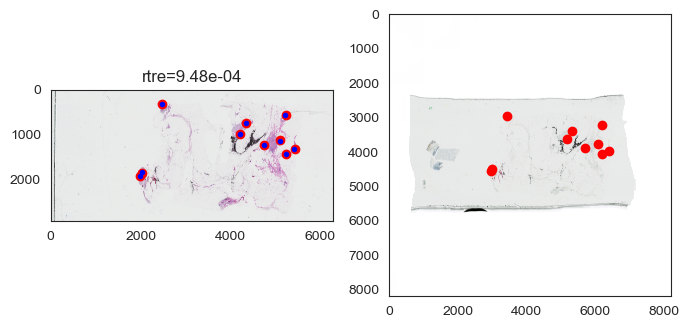

In [24]:
from omnialigner.preprocessing.pad import get_pad_size

plt = om.pl.plt

zoom_level = 3
om_data.set_zoom_level(zoom_level)
lm_F_ = np_lm_F*om_data.sizes[zoom_level]
lm_M_ = np_lm_M*om_data.sizes[zoom_level]

da_img_F = om.align.apply_nonrigid_HD(om_data, i_layer=0,tag="raw", overwrite_cache=True, unpad=True)
lm_F = om.align.apply_nonrigid_landmarks_HD(om_data, i_layer=0, keypoints_raw=lm_F_.copy(), zoom_level=zoom_level, unpad=True)
pad_size = get_pad_size(om_data, i_layer=0, zoom_level=om_data.zoom_level)

da_img_M = om.align.apply_nonrigid_HD(om_data, i_layer=1, tag="raw", overwrite_cache=True, unpad=False)
lm_M = om.align.apply_nonrigid_landmarks_HD(om_data, i_layer=1, keypoints_raw=lm_M_.copy(), zoom_level=zoom_level, unpad=False)

fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(da_img_F)

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(da_img_M)
ax2.plot(lm_M[:, 0], lm_M[:, 1], "ro")


lm_M[:, 0] -= pad_size[1][0]
lm_M[:, 1] -= pad_size[0][0]


ax1.plot(lm_M[:, 0], lm_M[:, 1], "ro")
ax1.plot(lm_F[:, 0], lm_F[:, 1], "b.")
img_diag = np.sqrt(da_img_F.shape[0]**2+da_img_F.shape[1]**2)
rtre = np.mean(om.metrics.rtre(lm_F, lm_M, img_diag).numpy())
ax1.set_title(f"rtre={rtre:.2e}")